# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [96]:
# import libraries
# pandas, numpy and seaborn
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import re
import datetime

# pyspark and related libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import greatest
from pyspark.sql.functions import col
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
from functools import reduce

# importing all the ML functions
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler
from pyspark.ml.feature import StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.param import Param, Params

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
!tar chvfz notebook.tar.gz *

Sparkify-zh.ipynb
Sparkify.ipynb
mini_sparkify_event_data.json
notebook.tar.gz
tar: notebook.tar.gz: file changed as we read it


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# reading the json 
df = spark.read.json('mini_sparkify_event_data.json')

In [5]:
# analyzing the schema of the dataframe created above
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# looking at first 2 records
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [7]:
# It will be easier to look at the above as a pandas dataframe. converting the df to a pandas dataframe
p_df = df.toPandas() 
p_df.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [8]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [9]:
# analyzing values of some of the columns
p_df.auth.unique(), p_df.level.unique(), p_df.method.unique(), p_df.page.unique()
#p_df.registration.unique(),
#p_df.status.unique(),
#p_df.ts.unique(),
#p_df.userAgent.unique(),

(array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object),
 array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object))

In [10]:
p_df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [11]:
# from the above we know that total rows are 286500 and both userIds and sessionIds have 286500 non null values, 
# that means using dropna will not be useful. We see that the df has blank values which we would need to filter out
p_df.userId.unique()

array(['30', '9', '74', '54', '', '4', '101', '78', '88', '95', '25',
       '142', '13', '45', '39', '87', '28', '131', '126', '146', '59',
       '15', '36', '120', '92', '33', '51', '27', '143', '140', '6', '124',
       '141', '93', '81', '40', '94', '113', '98', '137', '65', '53', '42',
       '115', '38', '58', '77', '52', '29', '70', '61', '46', '35', '132',
       '127', '136', '80', '110', '129', '121', '82', '100', '117', '18',
       '85', '118', '105', '96', '20', '55', '3', '12', '41', '73', '17',
       '86', '7', '67', '32', '5', '106', '114', '69', '99', '16', '49',
       '50', '24', '103', '102', '122', '75', '135', '128', '111', '112',
       '145', '66', '83', '44', '11', '91', '37', '90', '104', '138',
       '148', '107', '97', '109', '134', '10', '2', '144', '76', '119',
       '89', '14', '62', '19', '150', '68', '147', '8', '56', '34', '60',
       '125', '47', '133', '26', '43', '57', '149', '64', '21', '71',
       '108', '79', '123', '116', '152', '63', '139

In [12]:
df_final = df.filter(df["userId"] != "")

In [13]:
df_final.count()

278154

#### We dropped (286500 - 278154) = 8346 rows with missing userIds.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Defining Churn
A user is said to have churned if there is an event "Cancellation Confirmation" is present in one of the sessions page for a given userId.

In [14]:
# creating the flag 1 or 0 variable to identified churned users
users_churned = df_final.filter(df.page == "Cancellation Confirmation").select("userId").dropDuplicates()
users_churned_list = [(row['userId']) for row in users_churned.collect()]
df_final = df_final.withColumn("churn", df_final.userId.isin(users_churned_list))

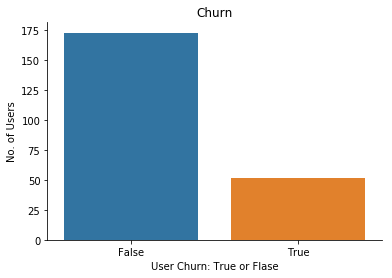

In [15]:
# looking at spread of churned vs non-churned users
churn_pd = df_final.dropDuplicates(["userId"]).groupby(["churn"]).count().sort("churn").toPandas()
ax = sns.barplot(x ='churn', y ='count', data=churn_pd)
plt.xlabel('User Churn: True or Flase')
plt.ylabel('No. of Users')
plt.title('Churn')
sns.despine(ax=ax);

In [16]:
churn_pd

,churn,count
0,False,173
1,True,52


We have 225 unique userIds with 52 churned users and 173 continuing users.

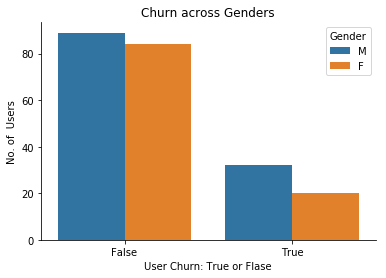

In [17]:
# looking at the distribution of userIds by gender and churn

churn_pd_gender = df_final.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

ax = sns.barplot(x ='churn', y ='count', hue ='gender', data = churn_pd_gender)
plt.xlabel('User Churn: True or Flase')
plt.ylabel('No. of  Users')
plt.legend(title ='Gender', loc ='best')
plt.title('Churn across Genders')
sns.despine(ax=ax);

In [18]:
churn_pd_gender

,churn,gender,count
0,False,M,89
1,False,F,84
2,True,F,20
3,True,M,32


Male users are more likely to churn than the Female users.

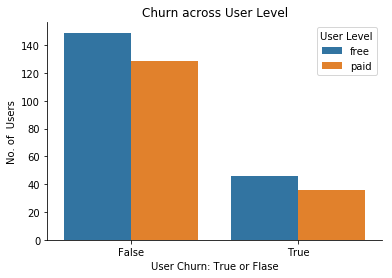

In [19]:
# looking at the churn distribution by paid or free users.

churn_pd_level = df_final.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()

ax = sns.barplot(x ='churn', y ='count', hue ='level', data = churn_pd_level)
plt.xlabel('User Churn: True or Flase')
plt.ylabel('No. of  Users')
plt.legend(title ='User Level', loc ='best')
plt.title('Churn across User Level')
sns.despine(ax=ax);

In [20]:
churn_pd_level

,churn,level,count
0,False,free,149
1,False,paid,129
2,True,paid,36
3,True,free,46


Paid users have a higher churn rate compared to Free users. This is obvious as a paid user as soon as he realizes that the service would want to save money and cancel his subscription.

In [21]:
# total number of songs users have listened to
tot_songs_pd = df_final.where('page == "NextSong"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
tot_songs_pd = tot_songs_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

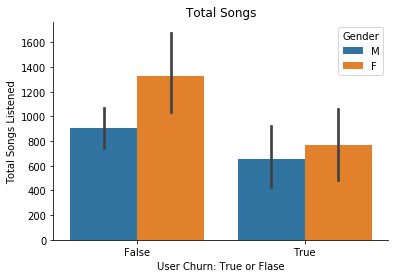

In [22]:
# visual representation of no. of songs across both genders
ax = sns.barplot(data = tot_songs_pd, x = 'churn', y = 'NextSong', hue='gender')
plt.xlabel('User Churn: True or Flase')
plt.ylabel('Total Songs Listened')
plt.legend(title='Gender', loc='best')
plt.title('Total Songs')
sns.despine(ax=ax);

Female users listened to more songs than Male users.

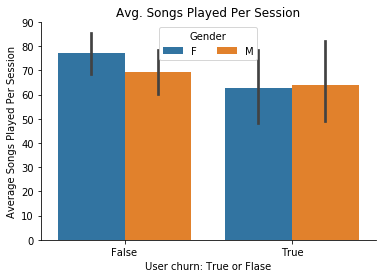

In [23]:
# visual representation for the number of songs played per session across both genders
tot_songs_session_pd = df_final.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.barplot('churn', y = 'avg_songs_played', hue = 'gender', data = tot_songs_session_pd)
plt.xlabel('User churn: True or Flase')
plt.ylabel('Average Songs Played Per Session')
plt.legend(title = 'Gender', loc = 'best', ncol = 2)
plt.title('Avg. Songs Played Per Session')
sns.despine(ax=ax);

Female users who keep using the service play more songs compared to the Female user who churn. In case of Male users the difference is marginal.

In [24]:
# adding time aspect to the analysis. 
ts_converted = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_final = df_final.withColumn('event_time', ts_converted('ts'))
df_final = df_final.withColumn('registration_time', ts_converted('registration'))
df_final = df_final.withColumn('time', ts_converted(df_final.ts))

In [25]:
# finding hour, date and weekday from the time
hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_final = df_final.withColumn("hour", hour(df_final.ts))

weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_final = df_final.withColumn("weekday", weekday(df_final.ts))

day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_final = df_final.withColumn("day", day(df_final.ts))

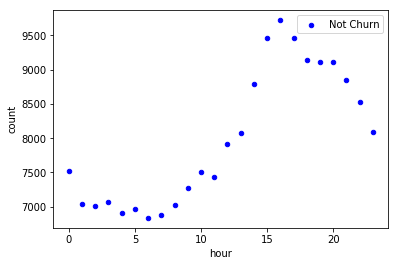

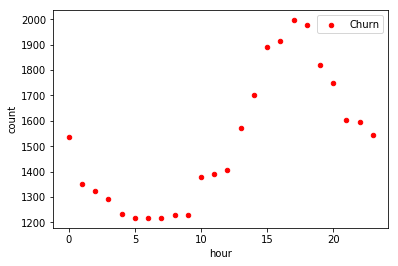

In [26]:
hour_df_pd = df_final.filter(df_final.page == "NextSong").groupby("churn", "hour").count().orderBy(df_final["hour"].cast("float")).toPandas()
hour_df_pd["hour"] = pd.to_numeric(hour_df_pd["hour"])
hour_df_pd[hour_df_pd.churn == 0].plot.scatter(x = "hour", y = 'count', color = 'Blue', label = 'Not Churn')
hour_df_pd[hour_df_pd.churn == 1].plot.scatter(x = "hour", y = 'count', color = 'Red', label = 'Churn')

For both the churned and on-churned users, the usage peaks around 3-5 pm and goes down by 10pm.

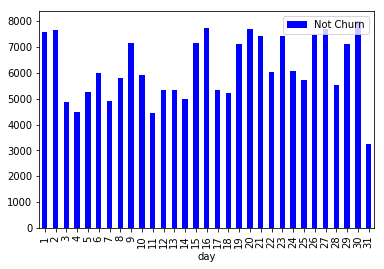

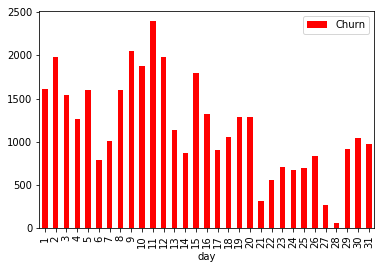

In [27]:
day_df_pd = df_final.filter(df_final.page == "NextSong").groupby("churn", "day").count().orderBy(df_final["day"].cast("float")).toPandas()
day_df_pd["day"] = pd.to_numeric(day_df_pd["day"])
day_df_pd[day_df_pd.churn == 0].plot.bar(x = "day", y = 'count', color = 'Blue', label = 'Not Churn')
day_df_pd[day_df_pd.churn == 1].plot.bar(x = "day", y = 'count', color = 'Red', label = 'Churn')

Usage for the churned userd decline by the end of the month could be because that's the time they churn and avoid next month's subscription charges. On the other hand, churned users use the service with ups and downs over entire days of the month.

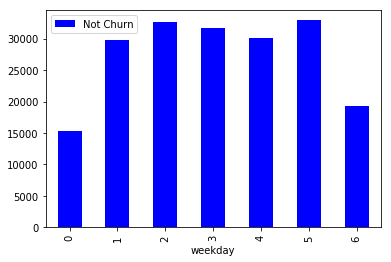

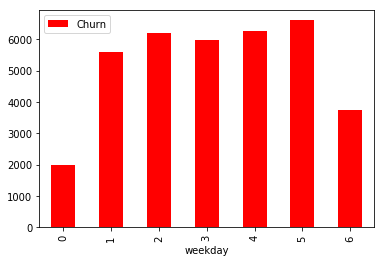

In [28]:
weekday_df_pd = df_final.filter(df_final.page == "NextSong").groupby("churn", "weekday").count().orderBy(df_final["weekday"].cast("float")).toPandas()
weekday_df_pd["weekday"] = pd.to_numeric(weekday_df_pd["weekday"])
weekday_df_pd[weekday_df_pd.churn == 0].plot.bar(x = "weekday", y = 'count', color = 'Blue', label = 'Not Churn')
weekday_df_pd[weekday_df_pd.churn == 1].plot.bar(x = "weekday", y = 'count', color = 'Red', label = 'Churn')

Monday to Sunday the usage patterns are not too different for both the churned and non-churned users.

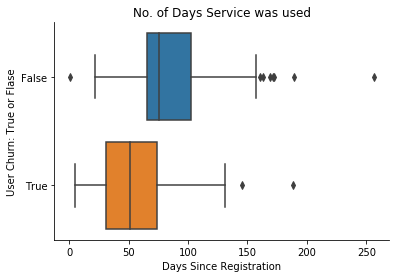

In [29]:
# After how long does a user churn once he has registered?
lifetime_pd = df_final \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',((df_final.ts-df_final.registration)/1000/3600/24))\
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', 'lifetime')\
    .toPandas()

ax = sns.boxplot(data = lifetime_pd, y = 'churn', x = 'lifetime', orient='h')
plt.xlabel('Days Since Registration')
plt.ylabel('User Churn: True or Flase')
plt.title('No. of Days Service was used')
sns.despine(ax=ax);

Users who churn, use the service for a shorter time compared to continuining users. It could be because the users realize it quick that they are not liking the service and churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### We will create the following features for our analysis
 - User Gender (Male of Female)
 - User Level (Paid or Free)
 - No. of days since Registration
 - Total Listening Time
 - Duration of Sessions (Min, Max and Avg)
 - No. of songs per Session
 - Total number of Sessions
 - Count of distinct artists listened to
 - Churn (the Y variable)
 - Like (Thumbs up/down)
 - Number of songs added to the playlist
 - Number of InviteFriends

Feature 1: User Gender - Male or Female

In [30]:
user_gender = df_final.select("userId", "gender")\
            .dropDuplicates()\
            .replace(["M", "F"], ["0", "1"], "gender")\
            .select("userId", col("gender").cast("int"))

user_gender.fillna(0)

DataFrame[userId: string, gender: int]

Feature 2: User Level - Paid or Free

In [31]:
user_paid = df_final.groupby("userId", "level").agg(max(df_final.ts).alias("finaltime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finaltime).alias("recent"))

user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finaltime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

user_recent_level.fillna(0)

DataFrame[userId: string, level: int]

Feature 3: No. of days since Registration

In [32]:
user_max_ts = df_final.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_final.select("userId", "registration").dropDuplicates().sort("userId")

user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regdays"))

user_reg_days.fillna(0)

DataFrame[userId: string, regdays: double]

Feature 4: Total Listening Time

In [33]:
listening_time = df_final \
    .select('userId','length') \
    .groupBy('userId') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')

listening_time.fillna(0)

DataFrame[userId: string, listen_time: double]

Feature 5: Duration of Sessions (Min, Max and Avg)

In [34]:
session_time = df_final.groupby("userId", "sessionId")\
                    .agg(((max(df_final.ts)-min(df_final.ts))/(1000*60)).alias("sessiontime"))

In [35]:
stats_session_time = session_time.groupby("userId")\
                        .agg(avg(session_time.sessiontime).alias("avgsessiontime"), min(session_time.sessiontime).alias("minsessiontime"), max(session_time.sessiontime).alias("maxsessiontime"))


stats_session_time.fillna(0)

DataFrame[userId: string, avgsessiontime: double, minsessiontime: double, maxsessiontime: double]

Feature 6: No. of Songs per Session

In [36]:
songs_per_session = df_final.filter(df_final.page == "NextSong")\
                    .groupby("userId", "sessionId")\
                    .count()

In [37]:
songs_per_session_avg = songs_per_session.groupby("userId")\
                        .agg(avg(songs_per_session["count"]).alias("avgsongspersession"))
songs_per_session_avg.fillna(0)

DataFrame[userId: string, avgsongspersession: double]

Feature 7: Total number of Sessions

In [38]:
total_session = df_final.select("userId", "sessionId")\
                    .dropDuplicates()\
                    .groupby("userId")\
                    .count()\
                    .withColumnRenamed("count", "totalsessions")

total_session.fillna(0)

DataFrame[userId: string, totalsessions: bigint]

Feature 8: Count of distinct artists listened to

In [39]:
count_artists = df_final.filter(df_final.page == "NextSong") \
                    .select("userId", "artist") \
                    .dropDuplicates() \
                    .groupby("userId") \
                    .count() \
                    .withColumnRenamed("count", "count_artists")

count_artists.fillna(0)

DataFrame[userId: string, count_artists: bigint]

Feature 9: Churn (the Y variable)

In [40]:
churn_label = df_final.select("userId", col("churn").cast("int").alias("churn_label")).dropDuplicates()

churn_label.fillna(0)

DataFrame[userId: string, churn_label: int]

Feature 10: Like (Thumbs up/down)

In [41]:
thumbs_up = df_final.select('userId','page') \
                .where(df_final.page == 'Thumbs Up') \
                .groupBy('userId') \
                .count() \
                .withColumnRenamed('count', 'thumbs_up') 

thumbs_down = df_final.select('userId','page') \
                .where(df_final.page == 'Thumbs Down') \
                .groupBy('userId') \
                .count() \
                .withColumnRenamed('count', 'thumbs_down') 

thumbs_up.fillna(0)
thumbs_down.fillna(0)

DataFrame[userId: string, thumbs_down: bigint]

Feature 11: Number of songs added to the playlist

In [42]:
adds_to_playlist = df_final.select('userId','page') \
                    .where(df_final.page == 'Add to Playlist') \
                    .groupBy('userId') \
                    .count() \
                    .withColumnRenamed('count', 'adds_to_playlist')

adds_to_playlist.fillna(0)

DataFrame[userId: string, adds_to_playlist: bigint]

Feature 12: Number of InviteFriends

In [43]:
friend_invites = df_final.select('userId','page') \
                    .where(df_final.page == 'Add Friend') \
                    .groupBy('userId') \
                    .count() \
                    .withColumnRenamed('count', 'friend_invites') 
friend_invites.fillna(0)

DataFrame[userId: string, friend_invites: bigint]

Merging all the dataframes together.

In [44]:
# first we will put all the dataframes with features into a list
list_of_features = []
list_of_features.append(user_gender)
list_of_features.append(user_recent_level)
list_of_features.append(user_reg_days)
list_of_features.append(listening_time)
list_of_features.append(stats_session_time)
list_of_features.append(songs_per_session_avg)
list_of_features.append(total_session)
list_of_features.append(count_artists)
list_of_features.append(churn_label)
list_of_features.append(thumbs_up)
list_of_features.append(thumbs_down)
list_of_features.append(adds_to_playlist)
list_of_features.append(friend_invites)

In [45]:
# we will now create a dataframe with the list of userIds to merge all the features with
df_userId = df_final.select("userId").dropDuplicates()

In [46]:
# as there are lot of dataframes we will write a function which can merge all of these dataframes together

def merge_features(df1, df2):
    """
    Function to merge the features dataframe using left join
    input: dataframes to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [47]:
# using the function in a for loop to merge all the features in the list of features

for feature in list_of_features:
    df_userId = merge_features(df_userId, feature)

In [48]:
# creating the final dataframe for modeling

df_model = df_userId.sort("userId")

+------+------+-----+------------------+------------------+------------------+-----------------+------------------+------------------+-------------+-------------+-----------+---------+-----------+----------------+--------------+
|userId|gender|level|           regdays|       listen_time|    avgsessiontime|   minsessiontime|    maxsessiontime|avgsongspersession|totalsessions|count_artists|churn_label|thumbs_up|thumbs_down|adds_to_playlist|friend_invites|
+------+------+-----+------------------+------------------+------------------+-----------------+------------------+------------------+-------------+-------------+-----------+---------+-----------+----------------+--------------+
|    10|     0|    1| 51.76265046296297|166866.37251000004|459.74722222222226|91.41666666666667|1547.9166666666667|112.16666666666667|            6|          565|          0|       37|          4|               9|            12|
|   100|     0|    1| 64.87377314814815|  672877.856590001| 316.5190476190476|      

In [49]:
df_model.persist()

DataFrame[userId: string, gender: int, level: int, regdays: double, listen_time: double, avgsessiontime: double, minsessiontime: double, maxsessiontime: double, avgsongspersession: double, totalsessions: bigint, count_artists: bigint, churn_label: int, thumbs_up: bigint, thumbs_down: bigint, adds_to_playlist: bigint, friend_invites: bigint]

In [50]:
df_model.show(1)

+------+------+-----+-----------------+------------------+------------------+-----------------+------------------+------------------+-------------+-------------+-----------+---------+-----------+----------------+--------------+
|userId|gender|level|          regdays|       listen_time|    avgsessiontime|   minsessiontime|    maxsessiontime|avgsongspersession|totalsessions|count_artists|churn_label|thumbs_up|thumbs_down|adds_to_playlist|friend_invites|
+------+------+-----+-----------------+------------------+------------------+-----------------+------------------+------------------+-------------+-------------+-----------+---------+-----------+----------------+--------------+
|    10|     0|    1|51.76265046296297|166866.37251000004|459.74722222222226|91.41666666666667|1547.9166666666667|112.16666666666667|            6|          565|          0|       37|          4|               9|            12|
+------+------+-----+-----------------+------------------+------------------+-----------

Saving the dataframe as a CSV to run models in future sessions.

In [53]:
# creating a path
out_path = "data/sparkify_model_data.csv"

#saving the csv
df_model.write.save(out_path, format="csv", header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [73]:
# reading the csv
out_path = "data/sparkify_model_data.csv"
data = spark.read.csv(out_path, header=True)

In [74]:
data.persist()

DataFrame[userId: string, gender: string, level: string, regdays: string, listen_time: string, avgsessiontime: string, minsessiontime: string, maxsessiontime: string, avgsongspersession: string, totalsessions: string, count_artists: string, churn_label: string, thumbs_up: string, thumbs_down: string, adds_to_playlist: string, friend_invites: string]

All the columns are read as strings converting the columns which ideally should be numeric to numeric

In [75]:
feature_list = data.columns[1:]
for fl in feature_list:
    fl_name = fl + "Num"
    data = data.withColumn(fl_name, data[fl].cast("float"))
    data = data.drop(fl)

In [76]:
data.persist()

DataFrame[userId: string, genderNum: float, levelNum: float, regdaysNum: float, listen_timeNum: float, avgsessiontimeNum: float, minsessiontimeNum: float, maxsessiontimeNum: float, avgsongspersessionNum: float, totalsessionsNum: float, count_artistsNum: float, churn_labelNum: float, thumbs_upNum: float, thumbs_downNum: float, adds_to_playlistNum: float, friend_invitesNum: float]

In [77]:
data.show(5)

+------+---------+--------+----------+--------------+-----------------+-----------------+-----------------+---------------------+----------------+----------------+--------------+------------+--------------+-------------------+-----------------+
|userId|genderNum|levelNum|regdaysNum|listen_timeNum|avgsessiontimeNum|minsessiontimeNum|maxsessiontimeNum|avgsongspersessionNum|totalsessionsNum|count_artistsNum|churn_labelNum|thumbs_upNum|thumbs_downNum|adds_to_playlistNum|friend_invitesNum|
+------+---------+--------+----------+--------------+-----------------+-----------------+-----------------+---------------------+----------------+----------------+--------------+------------+--------------+-------------------+-----------------+
|300009|      1.0|     1.0|101.224106|      357535.7|        326.64444|        11.633333|          1955.75|             79.27778|            18.0|          1025.0|           0.0|       132.0|          15.0|               44.0|             21.0|
|300010|      0.0|  

There are nulls in the data. We will look at where these nulls are coming from and then fill these null values with 0.

In [78]:
df = data.toPandas()

In [79]:
df.isnull().sum()

userId                    0
genderNum                 0
levelNum                  0
regdaysNum                0
listen_timeNum            0
avgsessiontimeNum         0
minsessiontimeNum         0
maxsessiontimeNum         0
avgsongspersessionNum     0
totalsessionsNum          0
count_artistsNum          0
churn_labelNum            0
thumbs_upNum              5
thumbs_downNum           22
adds_to_playlistNum      10
friend_invitesNum        19
dtype: int64

In [80]:
data = data.na.fill(0)

In [81]:
df = data.toPandas()
df.isnull().sum()

userId                   0
genderNum                0
levelNum                 0
regdaysNum               0
listen_timeNum           0
avgsessiontimeNum        0
minsessiontimeNum        0
maxsessiontimeNum        0
avgsongspersessionNum    0
totalsessionsNum         0
count_artistsNum         0
churn_labelNum           0
thumbs_upNum             0
thumbs_downNum           0
adds_to_playlistNum      0
friend_invitesNum        0
dtype: int64

In [82]:
data.columns

['userId',
 'genderNum',
 'levelNum',
 'regdaysNum',
 'listen_timeNum',
 'avgsessiontimeNum',
 'minsessiontimeNum',
 'maxsessiontimeNum',
 'avgsongspersessionNum',
 'totalsessionsNum',
 'count_artistsNum',
 'churn_labelNum',
 'thumbs_upNum',
 'thumbs_downNum',
 'adds_to_playlistNum',
 'friend_invitesNum']

In [83]:
# Now we need to vectorize our features

features = ['genderNum', 'levelNum', 'regdaysNum', 'listen_timeNum', 'avgsessiontimeNum', 'minsessiontimeNum',\
            'maxsessiontimeNum', 'avgsongspersessionNum', 'totalsessionsNum', 'count_artistsNum', 'thumbs_upNum',\
            'thumbs_downNum', 'adds_to_playlistNum', 'friend_invitesNum']
feature_assembler = VectorAssembler(inputCols = features, outputCol = "NumFeatures")
data = feature_assembler.transform(data)

In [84]:
# Using the Standard Scaler to standardize features

feature_scaler = StandardScaler(inputCol = "NumFeatures", outputCol = "features", withStd = True)
scaled = feature_scaler.fit(data)
data = scaled.transform(data)

In [86]:
# to run logistic regression model we need to convert the name of the churn variable to label

data = data.select(data.churn_labelNum.alias("label"), "features")

In [87]:
data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [88]:
# converting the label column to int
data = data.select(col("label").cast("int"),"features")

In [89]:
data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [90]:
# creating the train test split
train, test = data.randomSplit([0.7, 0.3], seed=42)

#### We will try below ML models for this analysis
 - DecisionTree
 - Logistic Regression
 - Gradient Boosted Trees
 - Random Forest
 - Linear SVM

In [91]:
# to make it easier to run, we will first write a function to run models in one go.

def create_model(model_name):
    model = model_name()

    model_fit = model.fit(train)
     
    results = model_fit.transform(test)
    evaluation = MulticlassClassificationEvaluator(predictionCol = "prediction")
    
    print('Model Run Successfully; Looking at metrics for', model_name, 'model:')
    print('Accuracy: {}'.format(evaluation.evaluate(results, {evaluation.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluation.evaluate(results, {evaluation.metricName: "f1"})))

In [92]:
create_model(LogisticRegression)

Model Run Successfully; Looking at metrics for <class 'pyspark.ml.classification.LogisticRegression'> model:
Accuracy: 0.7777777777777778
F-1 Score:0.7559454191033138


In [93]:
create_model(DecisionTreeClassifier)

Model Run Successfully; Looking at metrics for <class 'pyspark.ml.classification.DecisionTreeClassifier'> model:
Accuracy: 0.6527777777777778
F-1 Score:0.6497081193342875


In [94]:
create_model(RandomForestClassifier)

Model Run Successfully; Looking at metrics for <class 'pyspark.ml.classification.RandomForestClassifier'> model:
Accuracy: 0.75
F-1 Score:0.6916666666666667


In [95]:
create_model(GBTClassifier)

Model Run Successfully; Looking at metrics for <class 'pyspark.ml.classification.GBTClassifier'> model:
Accuracy: 0.6527777777777778
F-1 Score:0.6497081193342875


In [97]:
create_model(LinearSVC)

Model Run Successfully; Looking at metrics for <class 'pyspark.ml.classification.LinearSVC'> model:
Accuracy: 0.7361111111111112
F-1 Score:0.6242222222222222


Summarizing the results of the different models below:

 - Logistic Regression has an accuracy of: 0.7778 , and F1 score of:0.7559
 - Decision Tree Classifier has an accuracy of: 0.6528 , and F1 score of:0.6497
 - Random Forest Classifier has an accuracy of: 0.75 , and F1 score of:0.6917
 - Gradient Boosted Trees Classifier has an accuracy of: 0.6528 , and F1 score of:0.6497
 - Linear SVM Classifier has an accuracy of: 0.7361 , and F1 score of:0.6242

Surprisingly, Logistic Regression performs the best among the 5 classifier tried. <br>
Explanations for this could be:
 - The data is distributed in a fashion such that it can be easily linearly classified 
 - The signal to noise ratio is low
 
We feel the latter could be the case here as we only have limited data. If we use the entire dataset most likely we will have the RF or the GBT performing better. <br>
Also, Decision Tree Classifier and GBT Classifier had exactly the same F1 and Accuracy scores.

#### We will try Hyperparameter tuning to improve the performance of our best model i.e. Logistic Regression

In [100]:
model = LogisticRegression()

param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1, 0.5]) \
    .addGrid(model.elasticNetParam,[0.0, 0.05, 0.01]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()

cross_val = CrossValidator(estimator = model,
                          estimatorParamMaps = param_grid,
                          evaluator = MulticlassClassificationEvaluator(),
                          numFolds = 3)

model_fit = cross_val.fit(train)
model_fit.avgMetrics
    
results = model_fit.transform(test)
evaluation = MulticlassClassificationEvaluator(predictionCol = "prediction")
    
print('Metrics for Logistic Regression Classifier after Hypertuning the Parameters')
print('Accuracy: {}'.format(evaluation.evaluate(results, {evaluation.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluation.evaluate(results, {evaluation.metricName: "f1"})))

Metrics for Logistic Regression Classifier after Hypertuning the Parameters
Accuracy: 0.7777777777777778
F-1 Score:0.7476737821565407


Even when we tune the hyperparameters, we get the same Accuracy and F1 Score. Hence, our Logistic Model is good to go ahead with.

In [112]:
# Let us get the contributions of features for our Logistic Regression Model
coeffs = model_fit.bestModel.coefficientMatrix

coeff_dict = {
'gender':[coeffs[0,0]],
'level': [coeffs[0,1]],
'regdays': [coeffs[0,2]],
'listen_time' : [coeffs[0,3]],
'avgsessiontime': [coeffs[0,4]],
'minsessiontime' : [coeffs[0,5]],
'maxsessiontime' : [coeffs[0,6]],
'avgsongspersession' : [coeffs[0,7]],
'totalsessions' : [coeffs[0,8]],
'count_artists' : [coeffs[0,9]],
'thumbs_up' : [coeffs[0,10]],
'thumbs_down' : [coeffs[0,11]],
'adds_to_playlist' : [coeffs[0,12]],
'friend_invites' : [coeffs[0,13]]
    }

In [113]:
coeff_dict

{'gender': [-0.12141411889326216],
 'level': [0.23279891823015594],
 'regdays': [-0.90012665732732189],
 'listen_time': [-0.36983760307281766],
 'avgsessiontime': [0.03034648692000453],
 'minsessiontime': [-0.31892927612949518],
 'maxsessiontime': [-0.48030561091940865],
 'avgsongspersession': [-0.00011409846716281295],
 'totalsessions': [-0.011662619037653707],
 'count_artists': [0.015073942753318085],
 'thumbs_up': [-0.29512798078196484],
 'thumbs_down': [0.60940719590695258],
 'adds_to_playlist': [-0.39516051191291868],
 'friend_invites': [-0.31853579777512492]}

In [115]:
coeff_df = pd.DataFrame.from_dict(coeff_dict, orient = 'index', columns = ["coeff"])

In [116]:
coeff_df

,coeff
gender,-0.121414
level,0.232799
regdays,-0.900127
listen_time,-0.369838
avgsessiontime,0.030346
minsessiontime,-0.318929
maxsessiontime,-0.480306
avgsongspersession,-0.000114
totalsessions,-0.011663
count_artists,0.015074


In [117]:
coeff_df.index.name = 'Feature'

In [118]:
coeff_df

,coeff
Feature,
gender,-0.121414
level,0.232799
regdays,-0.900127
listen_time,-0.369838
avgsessiontime,0.030346
minsessiontime,-0.318929
maxsessiontime,-0.480306
avgsongspersession,-0.000114
totalsessions,-0.011663


In [133]:
coeff_df = coeff_df.reset_index()

In [127]:
coeff_df["contribution"] = coeff_df["coeff"]*100 / coeff_df["coeff"].abs().sum()

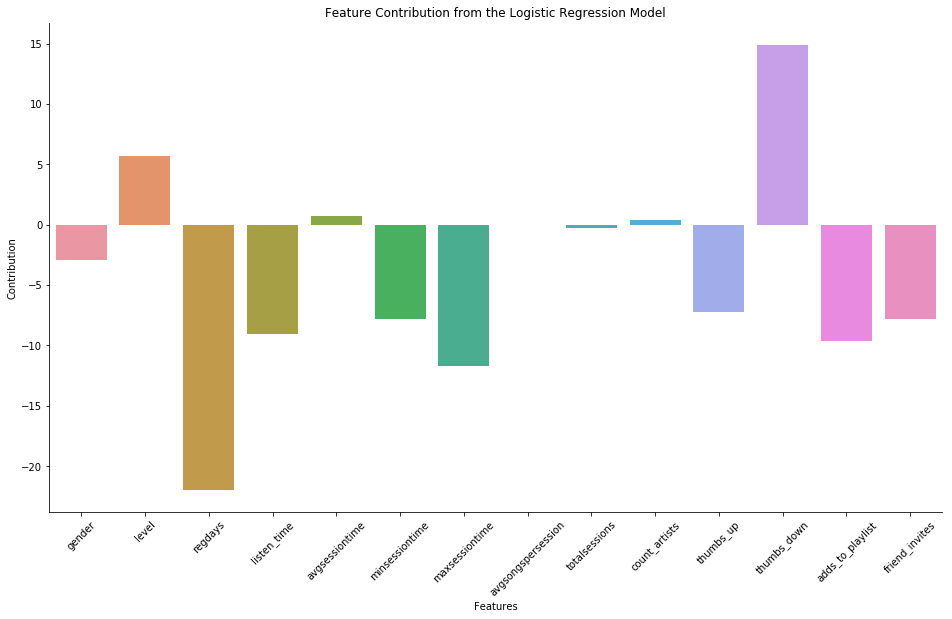

In [143]:
plt.figure(figsize=(16, 9))
ax = sns.barplot(data = coeff_df, y = "contribution", x = "Feature")
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.ylabel('Contribution')
plt.title('Feature Contribution from the Logistic Regression Model')
sns.despine(ax=ax);

In [144]:
coeff_df["importance"] = coeff_df["coeff"].abs()*100 / coeff_df["coeff"].abs().max()

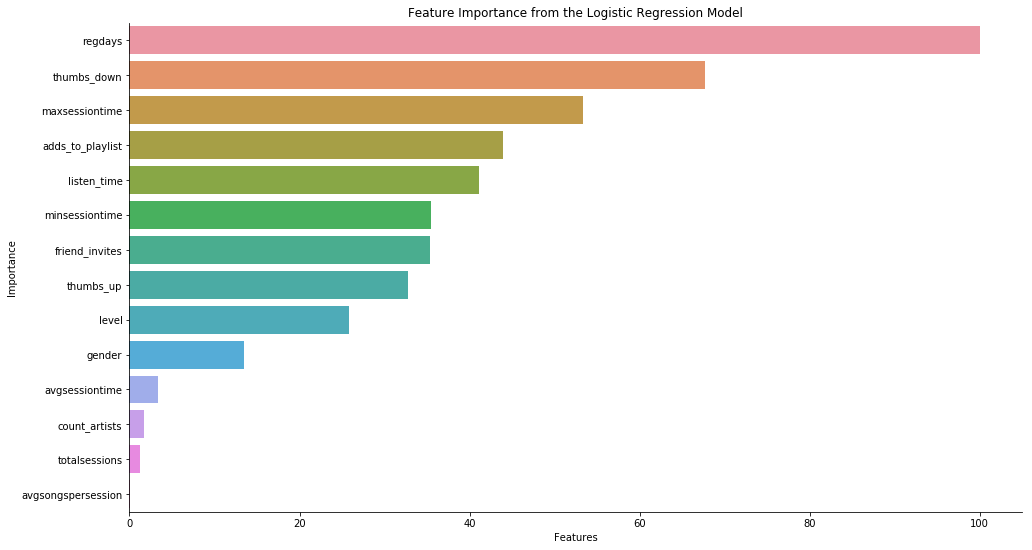

In [147]:
coeff_df = coeff_df.sort_values('importance',ascending = False)
plt.figure(figsize=(16, 9))
ax = sns.barplot(data = coeff_df, x = "importance", y = "Feature", orient = 'h')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from the Logistic Regression Model')
sns.despine(ax=ax);

#### Observations from the Logistic Regression Model Outputs:

The most important feature which contributes positively in predicting User likely to churn is no. of Thumbs Down by the user. So basically, if the user is not liking the songs available, he is more likely to churn.

The most important feature which contributes negatively in predicting User likely to churn is no. of Days since Registration of the user which means, the older users are less likely to churn compared to recently subscribed user.

If we look at the Top 5 features based on Importance:
 - No. of Days since Registration
 - No. of Thumbs Down or Dislikes
 - Maximum Session Time
 - No. of Songs added to the Playlist
 - Total Listening Time

# Conlcusion

## Summary

In this notebook, we implemented models to predict user(customer) churn. <br>
The first step in the analysis was to carry out initial data exploration, clean and data and remove rows without userIds. 
From there we first defined our Y variable or User Churn and then performed extensive Exploratory Data Analysis to understand the underlying patterns in the data better. <br>
EDA helped us in identifying features for our model and we developed more than 10 features for the analysis. <br>
As part of the modeling exercise we implemented 5 models: Logistic Regression, Decision Trees, RandomForest, GBT and Linear SVM and utilized model evaluation metrics - Accuracy and F1 Score to identify the best model from the 5. <br>
The best model based on the evaluation came out to be the Logistic Regression model. On which, we used cross validation and grid search to refine the model. <br>
The best model had an Accuracy of 0.78 and F1 score of 0.76. <br>
The top 5 important features predicting the likelihood of a user to churn are:
- No. of Days since Registration
- No. of Thumbs Down or Dislikes
- Maximum Session Time
- No. of Songs added to the Playlist
- Total Listening Time

# Improvements in the current implementation
We have obtained decent results in our current implementation. However, we can further improve the results by doing one or more of the following:
- Increase the number of observations. This is possible in our case if we utilize entire 128 GB of data
- Creating a few more features like users' city or state or the area like urban or rural
- Utilizing user surveys/interviews to validate the model outcomes and further enhance the feature set


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.